In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [4]:
with open(".awpy/maps/map-data.json", "r") as f:
    map_data_all = json.load(f)

print(type(map_data_all))

<class 'dict'>


# analysis over single round

In [5]:
selected_map = 'de_mirage'

In [6]:
selected_matches = matches_df[matches_df.map_name == selected_map]
selected_matches.head()

,client_name,map_name,tick_rate,playback_ticks,playback_frames_count,parsed_to_frame_idx,match_id,demo_id,competition_name,hltv_url,match_date,match_name
0,GOTV Demo,de_mirage,127,343251,342767,342784,0839a031-0e2c-4c03-b4bc-b5ba05fe669a,01746483-b3bd-4e4b-a2f2-0de97b17600d,PGL Major Antwerp 2022,https://www.hltv.org/matches/2356160/heroic-vs...,1652781600000,heroic-vs-vitality-pgl-major-antwerp-2022
0,GOTV Demo,de_mirage,127,471790,471564,471581,0a075b4d-576e-46f2-b944-fe9542faee54,04f0fb8f-a4d7-497c-857e-316300fadee3,IEM Katowice 2022,https://www.hltv.org/matches/2354381/furia-vs-...,1645124400000,furia-vs-astralis-iem-katowice-2022
0,GOTV Demo,de_mirage,127,426251,425998,426016,a98ffca7-e968-4a54-9e8f-22f101c2502b,022866a3-090e-42eb-ab8e-aa553a575ada,IEM Katowice 2021,https://www.hltv.org/matches/2346573/faze-vs-f...,1613905200000,faze-vs-furia-iem-katowice-2021
0,GOTV Demo,de_mirage,127,441259,440692,440707,a56115fd-a0ba-4eea-a618-91fd6c57177c,015f7c8d-2bc0-4d83-88e7-60648d2b221c,BLAST Premier Fall Showdown 2021,https://www.hltv.org/matches/2351973/heroic-vs...,1634034600000,heroic-vs-poggerz-blast-premier-fall-showdown-...
0,GOTV Demo,de_mirage,127,493224,492014,492029,f218743d-5e8b-436e-91bd-b7b3664c56c3,0418eb19-853e-4b56-955c-d3eedf2b7e12,BLAST Premier Spring Final 2021,https://www.hltv.org/matches/2349173/natus-vin...,1623853200000,natus-vincere-vs-faze-blast-premier-spring-fin...


## location based analysis over single round

In [7]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num"])
idx_f_df = flashes_df.set_index(["match_id","round_num"])
idx_sm_df = smokes_df.set_index(["match_id","round_num"])

### transform functions
so data fit the plotting format

In [8]:
def transform_coord(map_data,player_loc):
    result = player_loc.copy()
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result["x"] = (result["x"] - pos_x) / scale
    result["y"] = image_dim - (pos_y - result["y"]) / scale

    return result

In [9]:
def transform_flash(flashes):
    flashers_cols = [col for col in flashes.columns
                     if not (col.startswith('player_') or col == 'flash_duration')]
    flashers = flashes.loc[:, flashers_cols]
    
    flasheds_cols = [col for col in flashes.columns if not col.startswith('attacker_')]
    flasheds = flashes.loc[:, flasheds_cols]
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
        flashers.loc[:, "status"] = "flasher"
        flasheds.loc[:, "status"] = "flashed"
    
    flashers.columns = [col.replace("attacker_", "") for col in flashers.columns]
    flasheds.columns = [col.replace("player_", "") for col in flasheds.columns]
    
    result = pd.concat([flashers.drop_duplicates(), flasheds.drop_duplicates()])
    result.sort_values(["tick"],inplace=True)
    
    subset_col = [col for col in result.columns if col not in ["status","flash_duration"]]
    dup_idx = result.duplicated(subset=subset_col)
    keep_idx = result.duplicated(subset=subset_col,keep="last")
    result.loc[dup_idx,"status"] = "both"
    return result.loc[~keep_idx,:]

### plotting functions

In [10]:
def plot_map(map_name,fig_size,fig=None,ax=None):
    fig,ax = plt.subplots(figsize=fig_size)
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img,extent=[0,image_dim,0,image_dim])
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    ax.set_title(map_name.title())
    return fig,ax

In [11]:
def count_colorbar(fig):
    result = 0
    for ax in fig.axes:
        if "colorbar" in ax.get_label():
            result += 1
    return result

In [12]:
def plot_loc_unicode(player_loc, 
                     gradient_by, 
                     size,
                     color_by=None,
                     color_dict=None,
                     default_color="viridis",  # Default colormap when color_by is None
                     alpha=0.5,
                     marker_by=None,
                     marker_dict=None,
                     default_marker="o",       # Default marker when marker_by is None
                     fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    selected_col = ["x","y",gradient_by]
    if color_by is not None:
        selected_col.append(color_by)
    if marker_by is not None:
        selected_col.append(marker_by)
    transformed = player_loc.reset_index()[selected_col]
    
    # Create normalization using min and max from the dataframe
    vmin = transformed[gradient_by].min()
    vmax = transformed[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # Process color_by if it exists
    if color_by is not None:
        transformed[color_by] = transformed[color_by].str.lower()
    
    # Define side positions for colorbar
    side = ['left', 'right']
    
    n_colorbar = count_colorbar(fig)
    
    for idx, row in transformed.iterrows():
        if color_by is not None:
            cmap = plt.get_cmap(color_dict[row[color_by]])
        else:
            cmap = plt.get_cmap(default_color)
        
        # Apply normalization
        color_value = norm(row[gradient_by])
        color = cmap(color_value)

        if marker_by is None:
            marker_char = default_marker  # Use default marker
        else:
            marker_char = marker_dict[row[marker_by]]
            
        # Use ax.text for all cases
        ax.text(row["x"], row["y"], marker_char, 
                fontsize=size, color=color, ha='center', va='center',
                alpha=alpha)
        
    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")
    
    # Only create colorbars when color_by is specified
    if color_by is not None:
        for idx, (color_cat, cmap) in enumerate(list(color_dict.items())[:2-n_colorbar]):
            positions = transformed[transformed[color_by] == color_cat]
            dummy_scatter = ax.scatter(positions['x'], positions['y'], 
                                      c=positions[gradient_by], 
                                      cmap=cmap, s=0, alpha=.5,
                                      norm=norm)  # Apply the normalization
            cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                               fraction=0.046, shrink=0.6)
            cbar.set_label(f"{color_cat.upper()} {gradient_by.title()}", fontsize=8)
            cbar.ax.tick_params(labelsize=7)
    
    return fig, ax

### test plotting functions with players' location and flashes' location

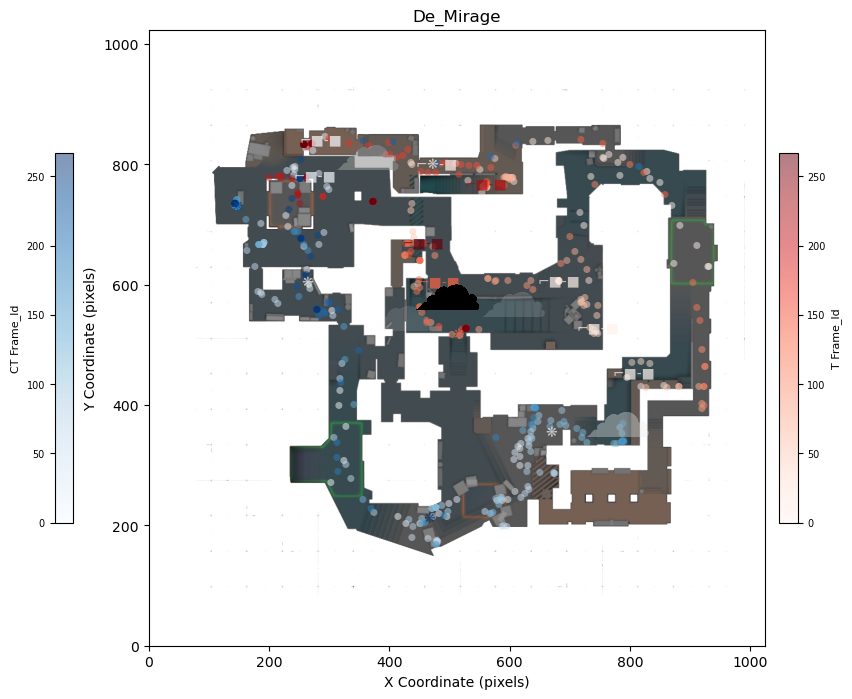

In [13]:
selected_match = selected_matches.iloc[0]
selected_round = 5

transformed_flash = transform_flash(idx_f_df.loc[(selected_match.match_id,selected_round)])
transformed_flash = transform_coord(map_data_all[selected_map],transformed_flash)
# transformed_flash = transformed_flash[transformed_flash["type"] == "flasher"]

transformed_loc = transform_coord(map_data_all[selected_map],
                                  idx_pf_df.loc[(selected_match.match_id,selected_round)].iloc[
                                  ::5
                                  ])

transformed_smoke = transform_coord(map_data_all[selected_map],
                                   idx_sm_df.loc[(selected_match.match_id,selected_round)])
side_color = {
    "ct" : "Blues",
    "t" : "Reds"
}

flash_marker = {
    "flasher" : "$\u274B$",
    "flashed" : "⌐■-■",
    "both" : "⌐$\u274B$-■"
}
img_fig, img_ax = plot_map(selected_map, (10, 8))

loc_fig, loc_ax = plot_loc_unicode(transformed_loc, 
                                  gradient_by="frame_id", 
                                  size=5,
                                  color_by="side",
                                  color_dict=side_color,
                                  default_marker="$\u2B24$",
                                  fig=img_fig, 
                                  ax=img_ax)

flash_fig, flash_ax = plot_loc_unicode(transformed_flash, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=flash_marker,
                                      alpha=0.7,
                                      fig=loc_fig, 
                                      ax=loc_ax)

smoke_fig, smoke_ax = plot_loc_unicode(transformed_smoke, 
                                      gradient_by="start_tick", 
                                      size=50,
                                      default_color="Grays",
                                      default_marker='$\u2601$',
                                      alpha=0.02,
                                      fig=flash_fig, 
                                      ax=flash_ax)

plt.show()

In [14]:
kills_df.columns

Index(['tick', 'seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'victim_steam_id',
       'victim_name', 'victim_team', 'victim_side', 'victim_x', 'victim_y',
       'victim_z', 'victim_view_x', 'victim_view_y', 'is_suicide',
       'is_teamkill', 'is_wallbang', 'penetrated_objects', 'is_first_kill',
       'is_headshot', 'victim_blinded', 'attacker_blinded', 'no_scope',
       'thru_smoke', 'distance', 'is_trade', 'weapon', 'weapon_class',
       'round_num', 'match_id', 'player_traded_name', 'player_traded_team',
       'player_traded_steam_id', 'assister_steam_id', 'assister_name',
       'assister_team', 'assister_side', 'flash_thrower_steam_id',
       'flash_thrower_name', 'flash_thrower_team', 'flash_thrower_side'],
      dtype='object')

In [15]:
round_kills = kills_df\
.groupby(["match_id","round_num"]).agg(
    ct_kills=("attacker_side",lambda side : (side == "CT").sum()),
    t_kills=("attacker_side",lambda side : (side == "T").sum())
).dropna(how="all")

/tmp/nix-shell.G4fEer/ipykernel_2355/250105463.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["match_id","round_num"]).agg(


In [62]:
idx_r_df = rounds_df.set_index(["match_id","round_num"])
idx_r_df["n_ticks"] = idx_r_df["end_tick"] - idx_r_df["start_tick"]
idx_r_df = idx_r_df[["n_ticks","winning_side","round_end_reason",
                     "ct_round_spend_money","ct_buy_type",
                     "t_round_spend_money","t_buy_type"]]
idx_r_df.head(5)

n_ticks winning_side  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            11876            T   
                                     2            15789            T   
                                     3            21424            T   
                                     4            46594           CT   
                                     5            13771           CT   

                                               round_end_reason  \
match_id                             round_num                    
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            TerroristsWin   
                                     2             TargetBombed   
                                     3             TargetBombed   
                                     4              TargetSaved   
                                     5                    CTWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   

                                                t_round_spend_money t_buy_type  
match_id                             round_num                                  
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                         3550   Full Eco  
                                     2                        17000   Semi Buy  
                                     3                        11500   Full Buy  
                                     4                        13750   Full Buy  
                                     5                        15200   Full Buy

In [63]:
flashes_df.columns

Index(['tick', 'seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'player_steam_id',
       'player_name', 'player_team', 'player_side', 'player_x', 'player_y',
       'player_z', 'player_view_x', 'player_view_y', 'flash_duration',
       'round_num', 'match_id'],
      dtype='object')

In [64]:
def count_sides(df,col,side,status_list):
    curr_df = df.loc[col.index.unique()[0]]
    count = curr_df[curr_df["side"]==side]["status"].isin(status_list).sum()
    # return count
    return count if count is not None else -120
all_tf_f = transform_flash(flashes_df).set_index(["match_id","round_num"])

round_flashes = all_tf_f.groupby(['match_id', 'round_num']).agg(
    ct_flashers=('side', lambda x : count_sides(all_tf_f,x,"CT",["flasher","both"])),
    t_flashers=('side', lambda x : count_sides(all_tf_f,x,"T",["flasher","both"])),
    ct_flasheds=('side', lambda x : count_sides(all_tf_f,x,"CT",["flashed","both"])),
    t_flasheds=('side', lambda x : count_sides(all_tf_f,x,"T",["flashed","both"])),
    avg_flash_duration=("flash_duration","mean")
).dropna(how="all")

/tmp/nix-shell.G4fEer/ipykernel_2355/3860996145.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round_flashes = all_tf_f.groupby(['match_id', 'round_num']).agg(


In [65]:
pd.concat([idx_r_df,round_kills,round_flashes],axis=1)

n_ticks winning_side  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            11876            T   
                                     2            15789            T   
                                     3            21424            T   
                                     4            46594           CT   
                                     5            13771           CT   
...                                                 ...          ...   
816e1612-9d2e-4893-af23-bda90c479598 13            8828           CT   
                                     14           13412           CT   
                                     15           10620           CT   
                                     16           45289           CT   
                                     17           15284            T   

                                               round_end_reason  \
match_id                             round_num                    
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            TerroristsWin   
                                     2             TargetBombed   
                                     3             TargetBombed   
                                     4              TargetSaved   
                                     5                    CTWin   
...                                                         ...   
816e1612-9d2e-4893-af23-bda90c479598 13                   CTWin   
                                     14                   CTWin   
                                     15                   CTWin   
                                     16             BombDefused   
                                     17           TerroristsWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                t_round_spend_money  \
match_id                             round_num                        
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                         3550   
                                     2                        17000   
                                     3                        11500   
                                     4                        13750   
                                     5                        15200  

In [66]:
damages_df.columns

Index(['tick', 'seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'attacker_strafe',
       'victim_steam_id', 'victim_name', 'victim_team', 'victim_side',
       'victim_x', 'victim_y', 'victim_z', 'victim_view_x', 'victim_view_y',
       'weapon', 'weapon_class', 'hp_damage', 'hp_damage_taken',
       'armor_damage', 'armor_damage_taken', 'hit_group', 'is_friendly_fire',
       'distance', 'zoom_level', 'round_num', 'match_id'],
      dtype='object')

In [83]:
idx_d_df = damages_df.set_index(["match_id","round_num"])
attackers_cols = [col for col in idx_d_df.columns
                if not col.startswith("victim_") and
                not col.endswith("_damage_taken")]
victims_cols = [col for col in idx_d_df.columns
                if not col.startswith("attacker_") and
                not col.endswith("_damage") and
                col != "zoom_level"
               ]

attackers = idx_d_df[attackers_cols]
victims = idx_d_df[victims_cols]

print(damages_df.hit_group.unique())
display(attackers)
display(victims)

['LeftLeg', 'Chest', 'Stomach', 'RightArm', 'Head', 'LeftArm', 'RightLeg', 'Generic', 'Neck']
Categories (9, object): ['Chest', 'Generic', 'Head', 'LeftArm', ..., 'Neck', 'RightArm', 'RightLeg', 'Stomach']


tick    seconds clock_time  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            7165  26.992188      01:29   
                                     1            7378  28.656250      01:27   
                                     1            7413  28.929688      01:27   
                                     1            7435  29.101562      01:26   
                                     1            7483  29.476562      01:26   
...                                                ...        ...        ...   
816e1612-9d2e-4893-af23-bda90c479598 17         265166  55.695312      00:60   
                                     17         265177  55.781250      00:60   
                                     17         265189  55.875000      00:60   
                                     17         266750  68.070312      00:47   
                                     17         270761  99.406250      00:16   

                                                attacker_steam_id  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1               7.656120e+16   
                                     1               7.656120e+16   
                                     1               7.656120e+16   
                                     1               7.656120e+16   
                                     1               7.656120e+16   
...                                                           ...   
816e1612-9d2e-4893-af23-bda90c479598 17              7.656120e+16   
                                     17              7.656120e+16   
                                     17              7.656120e+16   
                                     17              7.656120e+16   
                                     17              7.656120e+16   

                                               attacker_name attacker_team  \
match_id                             round_num                               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1               Tuurtle          MIBR   
                                     1                  exit          MIBR   
                                     1                  exit          MIBR   
                                     1                  exit          MIBR   
                                     1                Lucky       Astralis   
...                                                      ...           ...   
816e1612-9d2e-4893-af23-bda90c479598 17               gla1ve      Astralis   
                                     17               gla1ve      Astralis   
                                     17               gla1ve      Astralis   
                                     17              chopper   Team Spirit   
                                     17              chopper   Team Spirit   

                                               attacker_side   attacker_x  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    CT   564.715698   
                                     1                    CT   590.032104   
                                     1                    CT   592.368225   
                                     1                    CT   601.974548   
                                     1                     T   471.877350   
...                                                      ...          ...   
816e1612-9d2e-4893-af23-bda90c479598 17                   CT  -409.433258   
                                     17                   CT  -411.620880   
                                     17                   CT  -414.265076   
                                     17                    T  -781.655579   
                                     17                    T  1283.216064   

                                                 attacker_y  attacker_z  ...  \
match_id      

tick    seconds clock_time  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            7165  26.992188      01:29   
                                     1            7378  28.656250      01:27   
                                     1            7413  28.929688      01:27   
                                     1            7435  29.101562      01:26   
                                     1            7483  29.476562      01:26   
...                                                ...        ...        ...   
816e1612-9d2e-4893-af23-bda90c479598 17         265166  55.695312      00:60   
                                     17         265177  55.781250      00:60   
                                     17         265189  55.875000      00:60   
                                     17         266750  68.070312      00:47   
                                     17         270761  99.406250      00:16   

                                                  victim_steam_id victim_name  \
match_id                             round_num                                  
bfa9bbbe-bd16-4713-bd99-745378db05cb 1          76561197979669175      k0nfig   
                                     1          76561198110563159      Lucky    
                                     1          76561198110563159      Lucky    
                                     1          76561198110563159      Lucky    
                                     1          76561198010496342        exit   
...                                                           ...         ...   
816e1612-9d2e-4893-af23-bda90c479598 17         76561198040577200         sdy   
                                     17         76561198040577200         sdy   
                                     17         76561198040577200         sdy   
                                     17         76561197983956651      Magisk   
                                     17         76561198010511021      gla1ve   

                                                victim_team victim_side  \
match_id                             round_num                            
bfa9bbbe-bd16-4713-bd99-745378db05cb 1             Astralis           T   
                                     1             Astralis           T   
                                     1             Astralis           T   
                                     1             Astralis           T   
                                     1                 MIBR          CT   
...                                                     ...         ...   
816e1612-9d2e-4893-af23-bda90c479598 17         Team Spirit           T   
                                     17         Team Spirit           T   
                                     17         Team Spirit           T   
                                     17            Astralis          CT   
                                     17            Astralis          CT   

                                                   victim_x     victim_y  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1           105.020782  -320.336304   
                                     1           379.215027    -3.952997   
                                     1           439.399231   -25.700911   
                                     1           465.022491   -47.382427   
                                     1           595.946167  -224.704086   
...                                                     ...          ...   
816e1612-9d2e-4893-af23-bda90c479598 17         -409.258820  1353.239990   
                                     17         -410.598785  1353.264404   
                                     17         -412.064270  1353.292847   
                                     17        -1406.793335  1042.005737   
                                     17           92.832390  2236.9

In [ ]:
def transform_flash(flashes):
    flashers_cols = [col for col in flashes.columns
                     if not (col.startswith('player_') or col == 'flash_duration')]
    flashers = flashes.loc[:, flashers_cols]
    
    flasheds_cols = [col for col in flashes.columns if not col.startswith('attacker_')]
    flasheds = flashes.loc[:, flasheds_cols]
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
        flashers.loc[:, "status"] = "flasher"
        flasheds.loc[:, "status"] = "flashed"
    
    flashers.columns = [col.replace("attacker_", "") for col in flashers.columns]
    flasheds.columns = [col.replace("player_", "") for col in flasheds.columns]
    
    result = pd.concat([flashers.drop_duplicates(), flasheds.drop_duplicates()])
    result.sort_values(["tick"],inplace=True)
    
    subset_col = [col for col in result.columns if col not in ["status","flash_duration"]]
    dup_idx = result.duplicated(subset=subset_col)
    keep_idx = result.duplicated(subset=subset_col,keep="last")
    result.loc[dup_idx,"status"] = "both"
    return result.loc[~keep_idx,:]

In [84]:
transform_flash(flashes_df)

,tick,seconds,clock_time,steam_id,name,team,side,x,y,z,view_x,view_y,round_num,match_id,status,flash_duration
0,1050,8.203125,01:47,76561198059614402,zorte x LUKOIL,forZe,T,44.388569,785.332825,68.673157,351.293335,357.890625,1,6a2d54ef-429f-4236-9501-60e7549f32ce,flashed,0.323924
0,1050,8.203125,01:47,76561198154904607,Norwi x LUKOIL,forZe,T,-885.361084,563.997192,-31.968750,1.719360,327.222290,1,6a2d54ef-429f-4236-9501-60e7549f32ce,flasher,NaN
0,2181,10.125984,01:45,76561197961491680,tabseN,BIG,CT,1021.468750,-1742.977783,-415.969086,148.557129,359.538574,1,4571110d-ede4-4e15-af31-c94e53628ba8,flashed,4.512974
0,2181,10.125984,01:45,76561197960690195,FalleN,Imperial Esports,T,130.387466,-948.296936,-415.968750,359.445190,8.322144,1,4571110d-ede4-4e15-af31-c94e53628ba8,flasher,NaN
1,2195,10.236220,01:45,76561197996370184,VINI,Imperial Esports,T,-404.986694,-853.713684,-415.968750,328.084717,0.313110,1,4571110d-ede4-4e15-af31-c94e53628ba8,flasher,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,744778,93.952759,00:22,76561198035581101,afro,Double Poney,T,-1752.151855,713.819458,94.006538,22.972412,0.681152,34,850c8f0f-9869-487e-8177-d5c9d3417690,flashed,0.582811
434,744778,93.952759,00:22,76561198013295375,bodyy,Double Poney,T,-1253.321167,678.483948,56.538269,45.236206,0.961304,34,850c8f0f-9869-487e-8177-d5c9d3417690,flasher,NaN
434,744778,93.952759,00:22,76561198152075689,Duplicate,SKADE,CT,-557.637024,1277.967041,33.619232,201.566162,0.527344,34,850c8f0f-9869-487e-8177-d5c9d3417690,flashed,4.838655
436,745334,98.330711,00:17,76561198013295375,bodyy,Double Poney,T,-1029.976440,834.098450,74.540764,90.922852,2.296143,34,850c8f0f-9869-487e-8177-d5c9d3417690,flashed,3.113738
